In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

C:\Users\KIIT\AppData\Local\Temp\ipykernel_8300\2261059165.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
data = pd.read_csv("btc_6h.csv")
data.head()

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564


In [3]:
data.shape

(5959, 6)

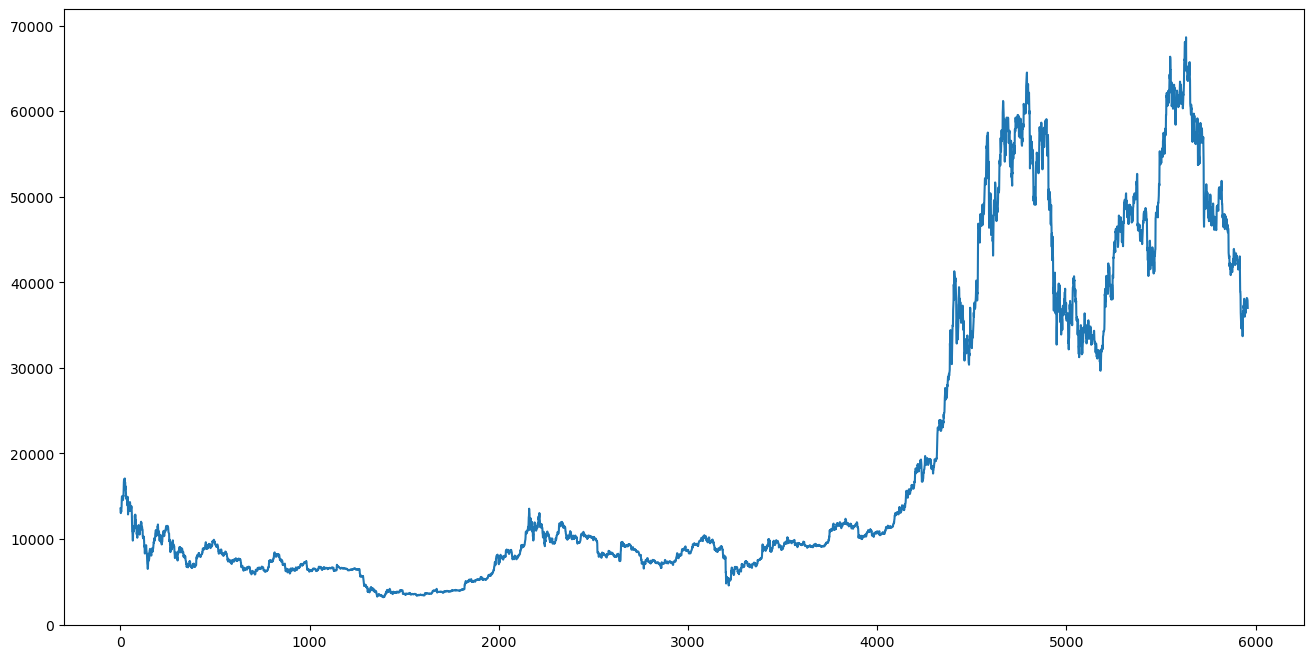

In [4]:
plt.figure(figsize=(16,8))
plt.plot(data['close'])
plt.show()

In [5]:
close_data = data['close']
close_data
close_df = pd.DataFrame(close_data,columns =['close'])
close_df.head()

,close
0,13558.99
1,13220.56
2,13022.00
3,13380.00
4,13166.95


In [6]:
data['next'] = data['close'].shift(-1)

In [7]:
data.head()

,datetime,open,high,low,close,volume,next
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182,13220.56
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392,13022.00
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747,13380.00
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523,13166.95
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564,13490.00


In [8]:
data.dtypes

datetime     object
open        float64
high        float64
low         float64
close       float64
volume      float64
next        float64
dtype: object

Checking Autocorrelation for Time Series Analysis

In [9]:
# Split into train and test sets
X = data['next'].values
size = int(len(X) * 0.8)

# Split first 80% for training
X_train_3 = X[:size]

# Split next 10% (80-90%) for validation
validation_size = int(size + 0.1 * len(X))
X_val_3 = X[size:validation_size]

# Split last 10% (90-100%) for testing
X_test_3 = X[validation_size:]

# Initialize a list to store prediction history
history = [x for x in X_train_3]

In [10]:
# Walk-forward validation using ARIMA model for validation data

val_pred = list()
for t in range(len(X_val_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    val_pred.append(yhat)

    # Update the history with the observed value
    obs = X_val_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=56449.352712, Expected=57749.090000
Predicted=57790.745149, Expected=58077.520000
Predicted=58039.688244, Expected=57947.670000
Predicted=57975.702948, Expected=58527.190000
Predicted=58477.811412, Expected=58405.080000
Predicted=58369.520184, Expected=58142.540000
Predicted=58147.735753, Expected=60851.920000
Predicted=60865.864874, Expected=60575.940000
Predicted=60582.521683, Expected=60100.480000
Predicted=60154.732337, Expected=59769.130000
Predicted=59615.336320, Expected=59679.970000
Predicted=59649.409020, Expected=59721.840000
Predicted=59745.818621, Expected=59864.390000
Predicted=59889.257077, Expected=60002.430000
Predicted=60014.944585, Expected=60207.010000
Predicted=60212.119147, Expected=60241.500000
Predicted=60236.902664, Expected=59749.400000
Predicted=59735.284895, Expected=59860.000000
Predicted=59847.693290, Expected=60668.740000
Predicted=60670.487553, Expected=62942.210000
Predicted=63017.221342, Expected=63332.850000
Predicted=63361.224265, Expected=6

Predicted=36730.237430, Expected=35389.100000
Predicted=35357.670927, Expected=32715.820000
Predicted=32708.383851, Expected=34655.250000
Predicted=34654.446375, Expected=35292.600000
Predicted=35445.529669, Expected=37600.010000
Predicted=37914.266635, Expected=37669.770000
Predicted=37598.091997, Expected=38796.290000
Predicted=38703.897313, Expected=38356.500000
Predicted=38155.849365, Expected=36537.160000
Predicted=36455.245205, Expected=37951.980000
Predicted=37804.290772, Expected=38324.720000
Predicted=38359.600866, Expected=39229.280000
Predicted=39425.291961, Expected=39850.650000
Predicted=39779.604796, Expected=38965.660000
Predicted=38913.682057, Expected=39241.910000
Predicted=39131.158421, Expected=38136.540000
Predicted=38058.590963, Expected=39690.010000
Predicted=39738.256771, Expected=39028.990000
Predicted=39056.250379, Expected=38529.980000
Predicted=38619.054665, Expected=36996.450000
Predicted=36861.962180, Expected=35351.650000
Predicted=35345.840226, Expected=3

Predicted=34131.138191, Expected=34809.730000
Predicted=34867.275627, Expected=34827.960000
Predicted=34858.505198, Expected=34635.010000
Predicted=34605.738339, Expected=33862.120000
Predicted=33806.712984, Expected=32884.560000
Predicted=32861.115765, Expected=32696.440000
Predicted=32696.696103, Expected=32863.830000
Predicted=32941.302693, Expected=32875.710000
Predicted=32975.267324, Expected=32996.180000
Predicted=33019.597649, Expected=32774.990000
Predicted=32766.693962, Expected=33481.070000
Predicted=33467.191916, Expected=33815.810000
Predicted=33828.299805, Expected=33649.030000
Predicted=33666.198445, Expected=33793.940000
Predicted=33725.046834, Expected=33397.270000
Predicted=33369.814205, Expected=33502.870000
Predicted=33499.575673, Expected=33590.530000
Predicted=33588.665159, Expected=33814.840000
Predicted=33847.525294, Expected=33892.810000
Predicted=33892.575196, Expected=34258.990000
Predicted=34247.801416, Expected=34330.250000
Predicted=34319.400711, Expected=3

Predicted=48563.500368, Expected=49322.470000
Predicted=49331.422810, Expected=48836.760000
Predicted=48822.378626, Expected=48501.870000
Predicted=48354.011346, Expected=49647.880000
Predicted=49590.180470, Expected=48821.870000
Predicted=48888.983281, Expected=49129.760000
Predicted=49107.107067, Expected=49132.040000
Predicted=49083.655937, Expected=48677.280000
Predicted=48720.765964, Expected=49239.220000
Predicted=49209.977645, Expected=50220.940000
Predicted=50235.399738, Expected=50394.850000
Predicted=50432.297336, Expected=49413.670000
Predicted=49363.335361, Expected=49488.850000
Predicted=49391.269910, Expected=49557.770000
Predicted=49564.060071, Expected=49429.990000
Predicted=49496.430961, Expected=48001.010000
Predicted=48009.046643, Expected=47674.010000
Predicted=47644.670474, Expected=48520.020000
Predicted=48553.164392, Expected=47570.010000
Predicted=47698.716268, Expected=48830.000000
Predicted=48813.976673, Expected=48973.320000
Predicted=48965.904994, Expected=4

In [11]:
# Convert validation and predictions to DataFrames for plotting
val_df = DataFrame(X_val_3, index=data['next'].index[size:validation_size], columns=['Actual'])
val_pred_df = DataFrame(val_pred, index=data['next'].index[size:validation_size], columns=['Predicted'])

# Evaluate forecasts for validation data
mse_val = mean_squared_error(val_df, val_pred_df)
rmse_val = np.sqrt(mse_val)

# Calculate R-squared (R^2) score for validation data
r2_val = r2_score(val_df, val_pred_df)

# Calculate Mean Absolute Error (MAE) for validation data
mae_val = mean_absolute_error(val_df, val_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for validation data
mape_val = np.mean(np.abs((np.array(val_df) - np.array(val_pred_df)) / np.array(val_df))) * 100

# Print results for validation data
print(f'Mean Squared Error (MSE) for Validation Data: {mse_val:.3f}')
print(f'Root Mean Squared Error (RMSE) for Validation Data: {rmse_val:.3f}')
print(f'R-squared (R^2) Score for Validation Data: {r2_val:.3f}')
print(f'Mean Absolute Error (MAE) for Validation Data: {mae_val:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Validation Data: {mape_val:.3f}%')

Mean Squared Error (MSE) for Validation Data: 932577.839
Root Mean Squared Error (RMSE) for Validation Data: 965.701
R-squared (R^2) Score for Validation Data: 0.989
Mean Absolute Error (MAE) for Validation Data: 693.863
Mean Absolute Percentage Error (MAPE) for Validation Data: 1.642%


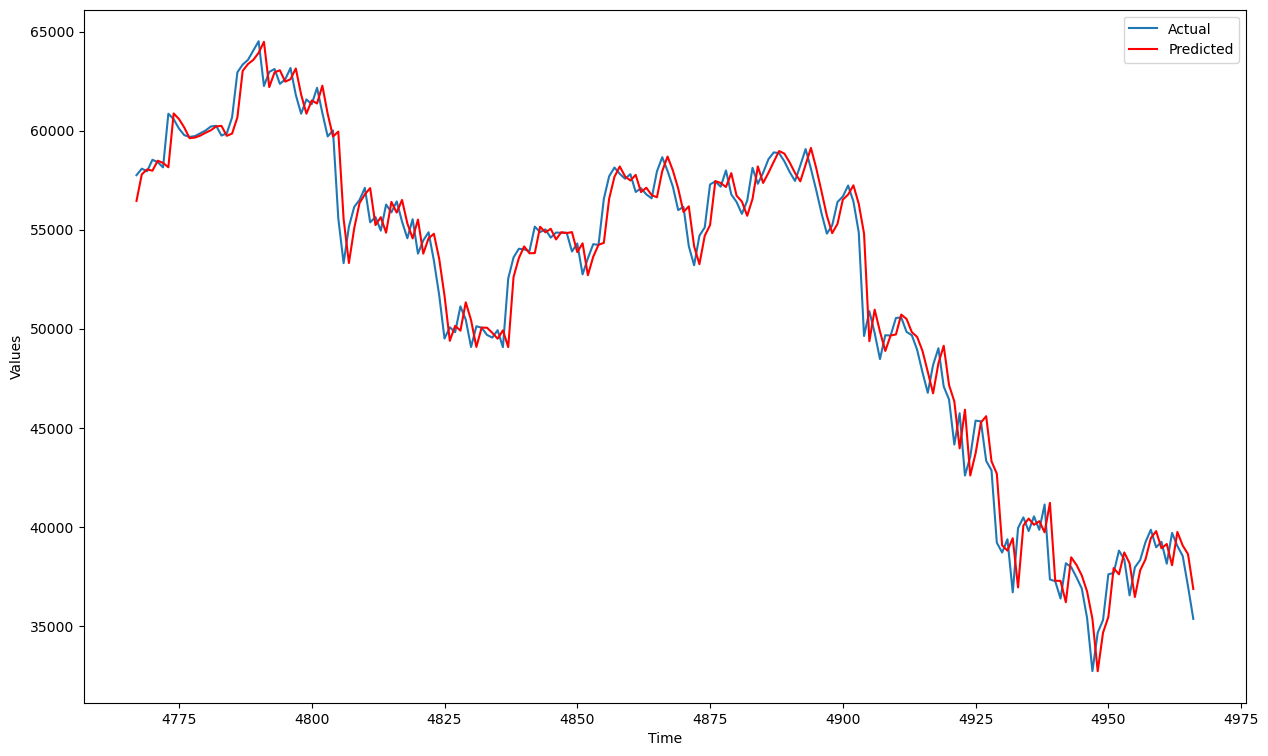

In [12]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values = val_df['Actual'].iloc[start_index:end_index]
predicted_values = val_pred_df['Predicted'].iloc[start_index:end_index]
time_index = val_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index, actual_values, label='Actual')

# Plot predicted values in red
plt.plot(time_index, predicted_values, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [13]:
test_pred = list()
for t in range(len(X_test_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    test_pred.append(yhat)

    # Update the history with the observed value
    obs = X_test_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=50218.486700, Expected=49902.940000
Predicted=49895.272380, Expected=49954.830000
Predicted=49967.925273, Expected=49915.640000
Predicted=49908.857240, Expected=49688.800000
Predicted=49712.322045, Expected=50198.780000
Predicted=50192.276097, Expected=50299.690000
Predicted=50313.714785, Expected=51756.880000
Predicted=51753.309211, Expected=51759.990000
Predicted=51748.482311, Expected=51400.670000
Predicted=51361.442139, Expected=51672.980000
Predicted=51562.700552, Expected=52663.900000
Predicted=52653.924334, Expected=52665.010000
Predicted=52699.426042, Expected=50941.480000
Predicted=50918.689516, Expected=46606.440000
Predicted=46515.777211, Expected=46863.730000
Predicted=46838.041004, Expected=46074.840000
Predicted=46298.972919, Expected=46394.090000
Predicted=46685.705054, Expected=46200.190000
Predicted=46240.944935, Expected=46048.310000
Predicted=46088.807306, Expected=46304.440000
Predicted=46290.000418, Expected=46293.150000
Predicted=46311.733075, Expected=4

Predicted=61998.992662, Expected=62476.650000
Predicted=62544.966371, Expected=62128.390000
Predicted=62089.990140, Expected=63411.270000
Predicted=63374.164962, Expected=64280.590000
Predicted=64279.683738, Expected=63779.410000
Predicted=63786.339470, Expected=63791.100000
Predicted=63695.065528, Expected=66363.020000
Predicted=66314.457040, Expected=66001.410000
Predicted=66061.787664, Expected=64825.710000
Predicted=64780.813735, Expected=64827.900000
Predicted=64680.981693, Expected=62487.000000
Predicted=62514.525523, Expected=62193.150000
Predicted=62231.147501, Expected=63013.040000
Predicted=63055.705475, Expected=63376.800000
Predicted=63529.457221, Expected=60576.030000
Predicted=60606.361488, Expected=60688.220000
Predicted=60609.802308, Expected=60990.000000
Predicted=61010.031876, Expected=61552.230000
Predicted=61698.467887, Expected=61239.010000
Predicted=61256.614347, Expected=61286.750000
Predicted=61256.986082, Expected=60900.000000
Predicted=60874.961776, Expected=6

Predicted=56608.817227, Expected=56480.340000
Predicted=56515.074082, Expected=56725.860000
Predicted=56758.317912, Expected=56959.770000
Predicted=56953.914177, Expected=54982.310000
Predicted=54996.853810, Expected=53601.050000
Predicted=53573.055353, Expected=47538.030000
Predicted=47511.563372, Expected=46489.670000
Predicted=46500.568682, Expected=48241.050000
Predicted=48411.039178, Expected=49152.470000
Predicted=49581.812876, Expected=49424.000000
Predicted=49542.927425, Expected=49242.580000
Predicted=49135.083285, Expected=49262.210000
Predicted=49183.116407, Expected=49396.330000
Predicted=49374.275646, Expected=48678.540000
Predicted=48684.375442, Expected=48577.780000
Predicted=48568.420328, Expected=48961.230000
Predicted=48964.025336, Expected=50441.920000
Predicted=50497.405784, Expected=50872.920000
Predicted=50898.575230, Expected=51456.200000
Predicted=51419.888947, Expected=50999.970000
Predicted=50902.769443, Expected=50588.950000
Predicted=50530.525403, Expected=5

Predicted=42949.475023, Expected=43071.880000
Predicted=43086.166266, Expected=43071.660000
Predicted=43084.138257, Expected=42664.680000
Predicted=42663.037008, Expected=42671.310000
Predicted=42661.854230, Expected=42110.830000
Predicted=42112.834542, Expected=42201.620000
Predicted=42221.115646, Expected=42097.250000
Predicted=42110.848593, Expected=41854.140000
Predicted=41883.872828, Expected=41489.040000
Predicted=41489.971685, Expected=42352.120000
Predicted=42360.265842, Expected=41762.550000
Predicted=41788.457569, Expected=42033.000000
Predicted=42042.136405, Expected=42151.010000
Predicted=42116.700347, Expected=41660.010000
Predicted=41677.534786, Expected=41879.200000
Predicted=41867.087040, Expected=42129.440000
Predicted=42127.587617, Expected=43025.850000
Predicted=43054.894981, Expected=40680.910000
Predicted=40674.750726, Expected=38909.010000
Predicted=38854.236355, Expected=38898.180000
Predicted=38863.445596, Expected=38382.500000
Predicted=38527.912971, Expected=3

In [14]:
# Convert test and predictions to DataFrames for plotting
test_df = DataFrame(X_test_3, index=data['next'].index[validation_size:], columns=['Actual'])
test_pred_df = DataFrame(test_pred, index=data['next'].index[validation_size:], columns=['Predicted'])

In [15]:
test_df.drop(test_df.tail(1).index, inplace=True)

In [16]:
test_pred_df.drop(test_pred_df.tail(1).index, inplace=True)

In [17]:
# Evaluate forecasts for test data
mse_test = mean_squared_error(test_df, test_pred_df)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) score for test data
r2_test = r2_score(test_df, test_pred_df)

# Calculate Mean Absolute Error (MAE) for test data
mae_test = mean_absolute_error(test_df, test_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for test data
mape_test = np.mean(np.abs((np.array(test_df) - np.array(test_pred_df)) / np.array(test_df))) * 100

# Print results for test data
print(f'Mean Squared Error (MSE) for Test Data: {mse_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 772822.537
Root Mean Squared Error (RMSE) for Test Data: 879.103
R-squared (R^2) Score for Test Data: 0.988
Mean Absolute Error (MAE) for Test Data: 598.761
Mean Absolute Percentage Error (MAPE) for Test Data: 1.191%


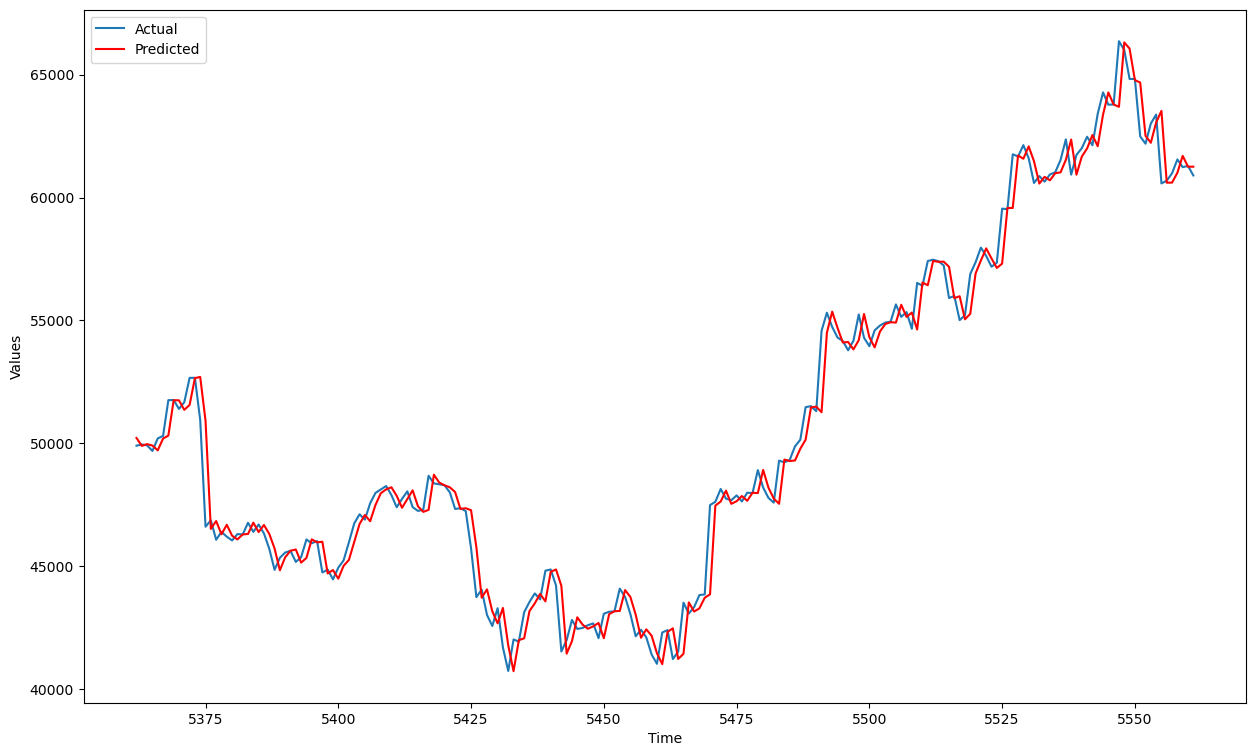

In [18]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values_test = test_df['Actual'].iloc[start_index:end_index]
predicted_values_test = test_pred_df['Predicted'].iloc[start_index:end_index]
time_index_test = test_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index_test, actual_values_test, label='Actual')

# Plot predicted values in red
plt.plot(time_index_test, predicted_values_test, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Out sample Testing

In [19]:
out_sample_test_2023 = pd.read_csv('BTC-USD.csv')

In [20]:
outsample_test_data = list(out_sample_test_2023['Close'].values)
history_all = list(data['close'].values)

In [21]:
outsample_test_data

[38743.273438,
 36952.984375,
 37154.601563,
 41500.875,
 41441.164063,
 42412.433594,
 43840.285156,
 44118.445313,
 44338.796875,
 43565.113281,
 42407.9375,
 42244.46875,
 42197.515625,
 42586.917969,
 44575.203125,
 43961.859375,
 40538.011719,
 40030.976563,
 40122.15625,
 38431.378906,
 37075.28125,
 38286.027344,
 37296.570313,
 38332.609375,
 39214.21875,
 39105.148438,
 37709.785156,
 43193.234375,
 44354.636719,
 43924.117188,
 42451.789063,
 39137.605469,
 39400.585938,
 38419.984375,
 38062.039063,
 38737.269531,
 41982.925781,
 39437.460938,
 38794.972656,
 38904.011719,
 37849.664063,
 39666.753906,
 39338.785156,
 41143.929688,
 40951.378906,
 41801.15625,
 42190.652344,
 41247.824219,
 41077.996094,
 42358.808594,
 42892.957031,
 43960.933594,
 44348.730469,
 44500.828125,
 46820.492188,
 47128.003906,
 47465.730469,
 47062.664063,
 45538.675781,
 46281.644531,
 45868.949219,
 46453.566406,
 46622.675781,
 45555.992188,
 43206.738281,
 43503.847656,
 42287.664063,
 4278

In [22]:
predictions = []
for t in range(len(outsample_test_data)):
    Model = ARIMA(history_all, order = (5,1,0))
    Model_fit = Model.fit()
    output = Model_fit.forecast(steps = 30)
    y_hat = output[0]
    predictions.append(y_hat)
    observation = outsample_test_data[t]
    history_all.append(observation)

    print('Predicted=%f, Expected=%f' % (y_hat, observation))


Predicted=36999.540327, Expected=38743.273438
Predicted=38756.675727, Expected=36952.984375
Predicted=36968.914762, Expected=37154.601563
Predicted=37185.451677, Expected=41500.875000
Predicted=41434.502309, Expected=41441.164063
Predicted=41507.161027, Expected=42412.433594
Predicted=42421.398515, Expected=43840.285156
Predicted=43592.397069, Expected=44118.445313
Predicted=44047.907031, Expected=44338.796875
Predicted=44288.171100, Expected=43565.113281
Predicted=43464.804605, Expected=42407.937500
Predicted=42360.163566, Expected=42244.468750
Predicted=42223.929242, Expected=42197.515625
Predicted=42237.290413, Expected=42586.917969
Predicted=42669.289307, Expected=44575.203125
Predicted=44616.982731, Expected=43961.859375
Predicted=43967.786841, Expected=40538.011719
Predicted=40496.988247, Expected=40030.976563
Predicted=39912.817162, Expected=40122.156250
Predicted=40129.961486, Expected=38431.378906
Predicted=38630.985590, Expected=37075.281250
Predicted=37162.641232, Expected=3

Predicted=23854.626979, Expected=23656.207031
Predicted=23573.035325, Expected=23336.896484
Predicted=23252.555981, Expected=23314.199219
Predicted=23296.182661, Expected=22978.117188
Predicted=22984.338788, Expected=22846.507813
Predicted=22865.644596, Expected=22630.957031
Predicted=22635.027287, Expected=23289.314453
Predicted=23306.180170, Expected=22961.279297
Predicted=22976.022205, Expected=23175.890625
Predicted=23194.701985, Expected=23809.486328
Predicted=23774.861278, Expected=23164.318359
Predicted=23174.423838, Expected=23947.642578
Predicted=23944.449456, Expected=23957.529297
Predicted=23915.351310, Expected=24402.818359
Predicted=24433.105565, Expected=24424.068359
Predicted=24394.928686, Expected=24319.333984
Predicted=24307.813524, Expected=24136.972656
Predicted=24111.895466, Expected=23883.291016
Predicted=23871.990633, Expected=23335.998047
Predicted=23339.129121, Expected=23212.738281
Predicted=23220.401211, Expected=20877.552734
Predicted=20890.884146, Expected=2

Predicted=22600.991733, Expected=23117.859375
Predicted=23119.893769, Expected=23032.777344
Predicted=23021.200704, Expected=23078.728516
Predicted=23095.654148, Expected=23031.089844
Predicted=23008.630899, Expected=23774.566406
Predicted=23770.742263, Expected=22840.138672
Predicted=22842.388361, Expected=23139.283203
Predicted=23143.094241, Expected=23723.769531
Predicted=23675.225105, Expected=23471.871094
Predicted=23516.384601, Expected=23449.322266
Predicted=23454.238936, Expected=23331.847656
Predicted=23290.626960, Expected=22955.666016
Predicted=22958.305380, Expected=22760.109375
Predicted=22763.430823, Expected=23264.291016
Predicted=23266.957870, Expected=22939.398438
Predicted=22963.605691, Expected=21819.039063
Predicted=21840.778145, Expected=21651.183594
Predicted=21618.602744, Expected=21870.875000
Predicted=21868.671664, Expected=21788.203125
Predicted=21857.086357, Expected=21808.101563
Predicted=21840.527105, Expected=22220.804688
Predicted=22210.863838, Expected=2

Predicted=29774.272583, Expected=30084.539063
Predicted=30089.333070, Expected=29176.916016
Predicted=29176.401210, Expected=29227.390625
Predicted=29226.940734, Expected=29354.972656
Predicted=29331.919137, Expected=29210.689453
Predicted=29256.169673, Expected=29319.246094
Predicted=29333.214246, Expected=29356.917969
Predicted=29348.560586, Expected=29275.308594
Predicted=29282.352229, Expected=29230.111328
Predicted=29226.613002, Expected=29675.732422
Predicted=29669.462536, Expected=29151.958984
Predicted=29160.624789, Expected=29178.679688
Predicted=29182.050337, Expected=29074.091797
Predicted=29046.061687, Expected=29042.126953
Predicted=29061.549282, Expected=29041.855469
Predicted=29048.962164, Expected=29180.578125
Predicted=29185.132893, Expected=29765.492188
Predicted=29769.226008, Expected=29561.494141
Predicted=29569.464598, Expected=29429.591797
Predicted=29426.144026, Expected=29397.714844
Predicted=29360.103979, Expected=29415.964844
Predicted=29414.385885, Expected=2

In [23]:
#converting vlaues to dataframe
predictions_df = pd.DataFrame( predictions,columns = ['predictions'])
outsample_df = pd.DataFrame(outsample_test_data, columns = ['close'])
print(outsample_df.shape , predictions_df.shape)

(704, 1) (704, 1)


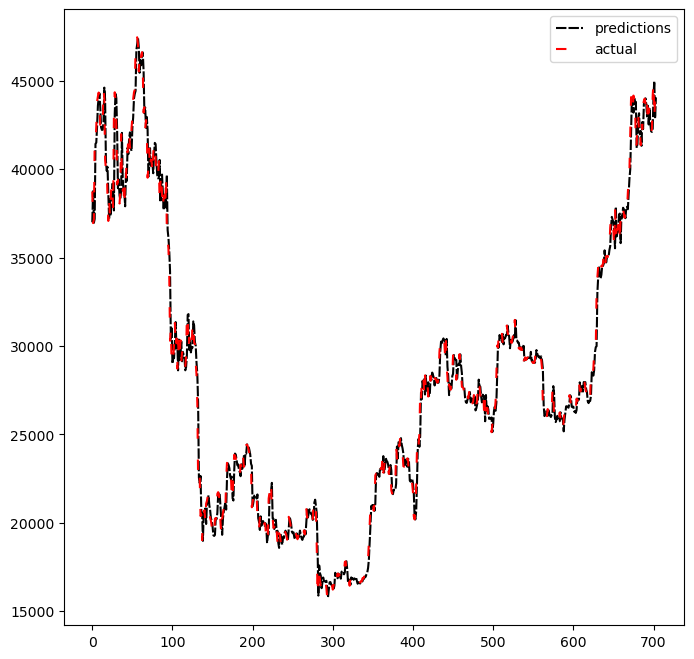

In [24]:

plt.figure(figsize = (8,8))
plt.plot(predictions_df['predictions'], label = "predictions",linestyle = (0,(5,1)), color = "black")
plt.plot(outsample_df['close'], label = "actual",linestyle = (0,(5,10)),color ="red")
plt.legend()
plt.show()


In [25]:
mse_outsample_test = mean_squared_error(predictions_df,outsample_df)
rmse_outsample_test = sqrt(mse_outsample_test)
r2_outsample_test = r2_score(predictions_df, outsample_df)
mae_outsample_test = mean_absolute_error(predictions_df, outsample_df)
mape_outsample_test = np.mean(np.abs((np.array(predictions_df) - np.array(outsample_df)) / np.array(outsample_df))) * 100

print(f'Mean Squared Error (MSE) for Test Data: {mse_outsample_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_outsample_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_outsample_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_outsample_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_outsample_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 718891.941
Root Mean Squared Error (RMSE) for Test Data: 847.875
R-squared (R^2) Score for Test Data: 0.989
Mean Absolute Error (MAE) for Test Data: 542.010
Mean Absolute Percentage Error (MAPE) for Test Data: 1.905%


In [26]:
out_sample_returns = out_sample_test_2023['Close'].pct_change()
returns = pd.DataFrame(np.array(out_sample_returns),columns = ['actual'])
returns

,actual
0,NaN
1,-0.046209
2,0.005456
3,0.116978
4,-0.001439
...,...
699,0.045005
700,0.017901
701,-0.046928
702,0.031081


In [27]:
predictions_df['return'] = predictions_df['predictions'].pct_change()
predictions_df

,predictions,return
0,36999.540327,NaN
1,38756.675727,0.047491
2,36968.914762,-0.046128
3,37185.451677,0.005857
4,41434.502309,0.114266
...,...,...
699,42286.222421,0.004109
700,44201.472082,0.045293
701,44982.351664,0.017666
702,42875.174008,-0.046845


In [28]:
return_df = pd.DataFrame(np.array(out_sample_returns),columns = ['actual'])
return_df['prediction'] = predictions_df['return']
return_df

,actual,prediction
0,NaN,NaN
1,-0.046209,0.047491
2,0.005456,-0.046128
3,0.116978,0.005857
4,-0.001439,0.114266
...,...,...
699,0.045005,0.004109
700,0.017901,0.045293
701,-0.046928,0.017666
702,0.031081,-0.046845


In [29]:
return_df['actual_close'] = out_sample_test_2023['Close']
return_df['prediction_close'] = predictions_df['predictions']
return_df.head(10)

,actual,prediction,actual_close,prediction_close
0,NaN,NaN,38743.273438,36999.540327
1,-0.046209,0.047491,36952.984375,38756.675727
2,0.005456,-0.046128,37154.601563,36968.914762
3,0.116978,0.005857,41500.875000,37185.451677
4,-0.001439,0.114266,41441.164063,41434.502309
5,0.023437,0.001754,42412.433594,41507.161027
6,0.033666,0.022026,43840.285156,42421.398515
7,0.006345,0.027604,44118.445313,43592.397069
8,0.004995,0.010449,44338.796875,44047.907031
9,-0.017449,0.005455,43565.113281,44288.171100


In [30]:
return_df['actual_return'] = return_df['actual'].cumsum()
return_df['strat_return'] = return_df['prediction'].cumsum()
return_df

,actual,prediction,actual_close,prediction_close,actual_return,strat_return
0,NaN,NaN,38743.273438,36999.540327,NaN,NaN
1,-0.046209,0.047491,36952.984375,38756.675727,-0.046209,0.047491
2,0.005456,-0.046128,37154.601563,36968.914762,-0.040753,0.001363
3,0.116978,0.005857,41500.875000,37185.451677,0.076225,0.007220
4,-0.001439,0.114266,41441.164063,41434.502309,0.074786,0.121487
...,...,...,...,...,...,...
699,0.045005,0.004109,44167.332031,42286.222421,0.420326,0.423415
700,0.017901,0.045293,44957.968750,44201.472082,0.438227,0.468707
701,-0.046928,0.017666,42848.175781,44982.351664,0.391299,0.486374
702,0.031081,-0.046845,44179.921875,42875.174008,0.422379,0.439529


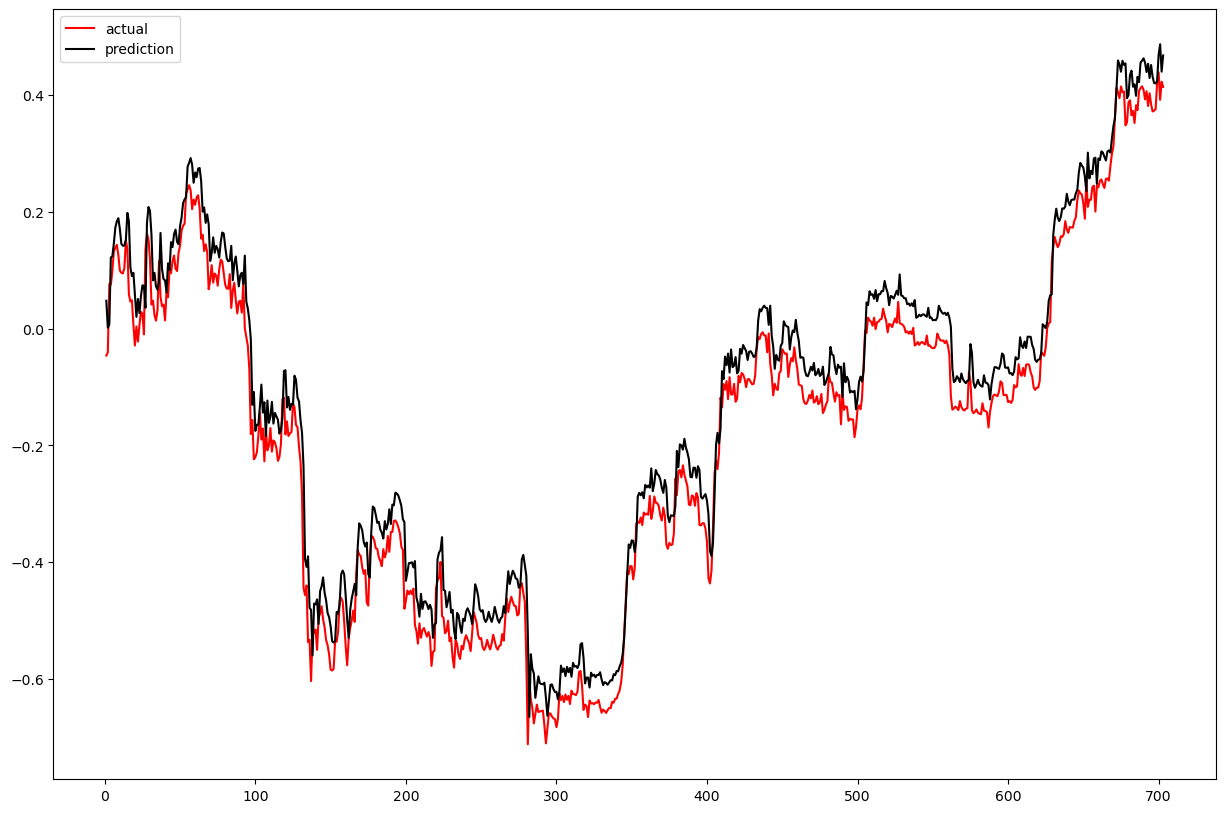

In [31]:
plt.figure(figsize = (15,10))
plt.plot(return_df['actual_return'] , label = 'actual', color = 'red')
plt.plot(return_df['strat_return'], label = 'prediction', color = 'black')
plt.legend()
plt.show()

# Creating a trading startergy

In [32]:
prediction_close = return_df['prediction_close']
actual_close = return_df['actual_close']

# TRADING STARTERGY

### 1. Create a threshold value - This value determine we will take a action or just pass




### 2. if the prediction value passes the threshold in positive direction we will buy the stock else we will sell the stock at current price
            

In [66]:

threshold = -0.06 #This is the threshold ( predicted drawdown allowed ) value 
steps = 50 # steps the model will look into the future
net_earning = 0
total_investment = 100000  # USD 100,000
current_money = total_investment
current_investment = 0
bitcoin_count = 0
max_trade_duration = 0

winning_trade = [] #Storing all winning trades
loosing_trade = [] #Storing all loosing trades
returns = []  # To store daily returns
previous_investment = current_money #Storing previous investments 
loosing_trade_count = 0
winning_trade_count = 0 
earning = []

for i in range(0, len(return_df) - steps):
    future = prediction_close[i + steps]
    current = actual_close[i]
    change = (future - current) / current

    returns.append(change)

    if change < threshold and current_investment != 0:
        # Sell
        current_money = bitcoin_count * current
        current_investment = 0
        earning.append(current_money)
    
        profit = current_money - previous_investment
        
        if(profit < 0):
            loosing_trade.append(profit)
            loosing_trade_count += 1
        else:
            winning_trade.append(profit)
            winning_trade_count += 1
            
        # Update the trade duration
        if trade_start_date is not None:
            current_trade_duration = i - trade_start_date
            max_trade_duration = max(max_trade_duration, current_trade_duration)
            trade_start_date = None

    elif current_investment == 0:
        # Buy
        current_investment = current_money
        bitcoin_count = current_investment / current
        # Record trade start date
        trade_start_date = i

    else:
        continue

if current_investment == 0:
    net_earning = current_money
else:
    net_earning = current_investment

# Handling edge case if the current trade is not finished yet
if current_investment == 0 and trade_start_date is not None:
    current_trade_duration = len(prediction_close) - trade_start_date
    max_trade_duration = max(max_trade_duration, current_trade_duration)

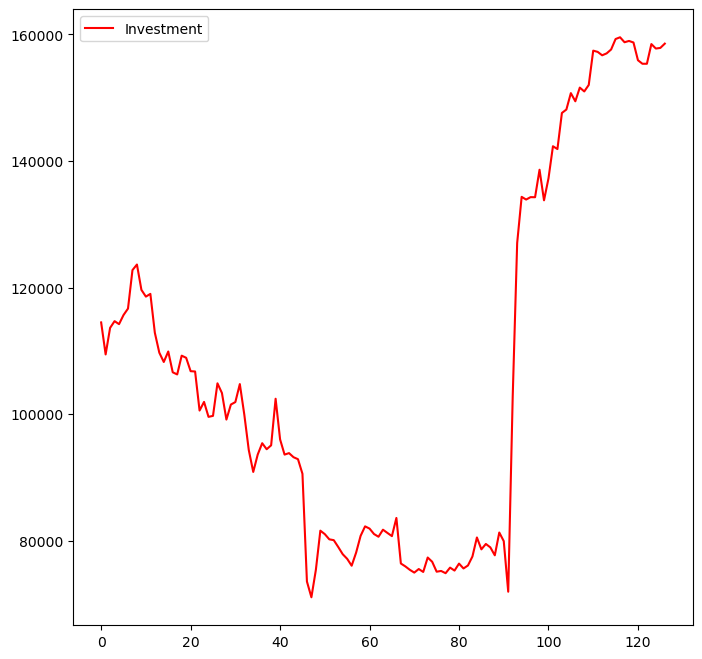

In [68]:
plt.figure(figsize=(8,8))
plt.plot(earning,color = "red",label = "Investment")
plt.legend()
plt.show()


## Trading Strategy metrics

In [65]:
# Max Drawdown
risk_free_rate = 0.02
daily_returns = predictions_df['predictions'].pct_change()
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - cumulative_max) / cumulative_max
max_drawdown = min(drawdown[1:]) * 100

# Profits
strategy_return = net_earning - total_investment

# Calculate Sharpe Ratio
average_return = np.mean(returns) * 252 * 2  # Assuming 252 trading days in a year
volatility = np.std(returns) * np.sqrt(252 * 2)  # Annualized volatility
sharpe_ratio = (average_return - risk_free_rate) / volatility

print(f"Net Earning: ${net_earning:.3f}")
print(f"Stratergy return: ${strategy_return:.3f}")
print(f"Max Trade Duration: {max_trade_duration} days")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown:.3f} %")

#buy and hold return = (Final price - intial price) * BTC_count
initial_price = actual_close[0]
BTC_count = total_investment / initial_price
final_price = actual_close[len(actual_close) - 1]
bhr_return = (final_price - initial_price) * BTC_count
bhr_earning = final_price * BTC_count
print(f'Total benchmark return {bhr_earning:.3f}')
print(f'Buy and hold return {bhr_return:.3f}')

# percent increase in net profit generated by using the model strategy
# percent_increase = ( (net_earning - benchmark_earning)/benchmark_earning ) * 100
profit_increase = (net_earning- bhr_earning) / bhr_earning
percent_profit_increase = profit_increase * 100
print(f'Net Profit Exceeding Benchmark Return of the Model : {percent_profit_increase:.3f} %')

# calculating risk-to-reward ratio

#calculating average loosing trade
total_loosing_trade = sum(loosing_trade)
average_loosing_trade = total_loosing_trade / loosing_trade_count
#calculating average winning trade
total_winning_trade = sum(winning_trade)
average_winnning_trade = total_winning_trade / winning_trade_count

risk_to_reward_ratio = average_winnning_trade / abs(average_loosing_trade)
print(f'risk to reward ratio : {risk_to_reward_ratio:.3f}')

Net Earning: $158546.788
Stratergy return: $58546.788
Max Trade Duration: 74 days
Sharpe Ratio: 2.555
Maximum Drawdown: -66.732 %
Total benchmark return 113006.219
Buy and hold return 13006.219
Net Profit Exceeding Benchmark Return of the Model : 40.299 %
risk to reward ratio : 1.740


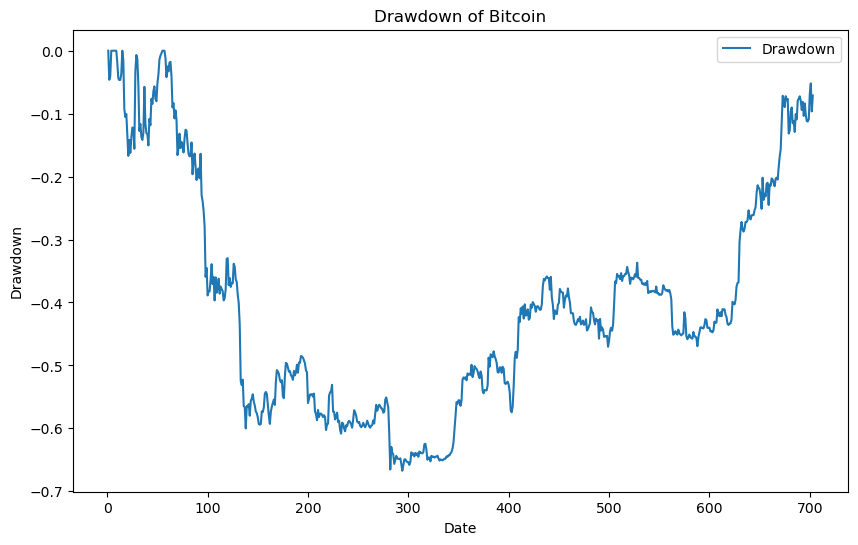

In [34]:
plt.figure(figsize=(10,6))
drawdown.plot(label='Drawdown')
plt.title('Drawdown of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()